### Exploratory data analysis

### Achtergrond

We gaan werken aan het opsporen van Invasief ductaal carcinoom (Invasive ductal carcinoma, IDC). De oorspronkelijke dataset bestond uit 279 scans van borsten met en dergelijk carcicoom. Van deze oorspronkelijke data zijn 277.524 uitsneden gemaakt: 198.738 IDC-negatief and 78.786 IDC positief. Elke patiënt heeft z'n eigen directory die genoemd is naar het patiëntnummer. In deze directories vind je telkens weer twee andere directories: 0 en 1 met hierin de uiteindelijke uitsneden. De namen van al deze plaatjes hebben hetzelfde algemene formaat:

<patiennr>_idx5_<x-coord>_<y_coord>_class[01].png

De uitsneden die in de klasse 0 zitten betreffen gezond weefsel, de uitsneden in de directory 1 bevatten (delen van) tumoren. De bedoeling van deze opdracht is om een netwerk te creëren dat in staat is het gezonde van het ongezonde weefsteld te onderscheiden.

### Laad Libraries 

In [3]:
# Voor mappenbeheer
import os 
# Voor machine learning
import tensorflow as tf 
# Voor visualisaties
import matplotlib.pyplot as plt  
# Voor datamanipulatie
import numpy as np  
# Voor laden en bewerken van afbeeldingen
from PIL import Image 

### Laad de dataset

Eerst laden we de dataset:

In [ ]:
data_path = "../data/idc_regular"

Dan checken we het aantal patienten waar we mee werken:

In [19]:
# Controleer aantal patiënten
patient_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
print(f"Aantal patiënten: {len(patient_dirs)}")

Aantal patiënten: 279


Er zijn inderdaad 279 directories aanwezig. We kiezen eerst 1 patient om de structuur van de data te bekijken. We gebruiken de library PIL met de module Image om RGB afbeeldingen (kleurenafbeeldingen) te openen en zetten het gelijk om in een array:

In [37]:
# Stel patiënt ID in
patient_id = '../data/idc_regular/8863'

# Lijsten voor positieve en negatieve afbeeldingen
imgs_positive = []
imgs_negative = []

# Vul de lijsten met bestanden
imgs_negative.extend(os.listdir(f'{patient_id}/0/'))
imgs_positive.extend(os.listdir(f'{patient_id}/1/'))

# Kies een willekeurige positieve afbeelding
idx = np.random.choice(len(imgs_positive))
img = Image.open(f'{patient_id}/1/{imgs_positive[idx]}') 

# Toon details van de afbeelding
print(img.format)
print(img.size)
print(img.mode)

# Zet afbeelding om naar een numpy-array en toon de vorm
print(np.asarray(img).shape)

PNG
(50, 50)
RGB
(50, 50, 3)


De output is PNG (50, 50) en RGB (50, 50, 3). De eerste twee values zijn hoogte en breedte en de derde input zijn de kleurkanalen. Er staat dus  (50 pixels, 50 pixels, [rood, blauw, groen]). Laten we nu de afbeeldingen plotten:

cancerous:


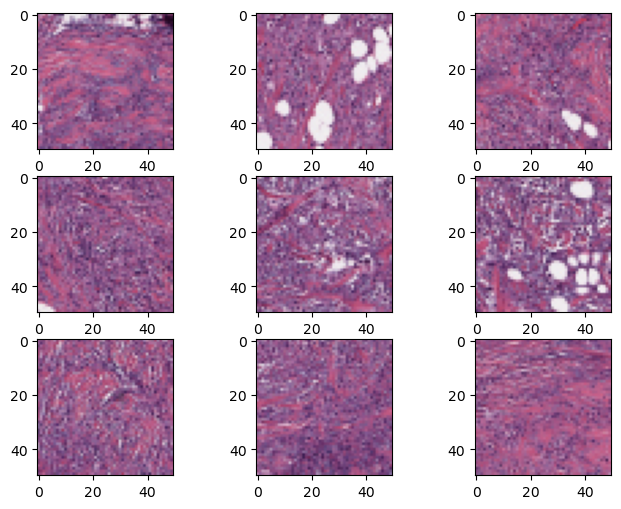

healthy:


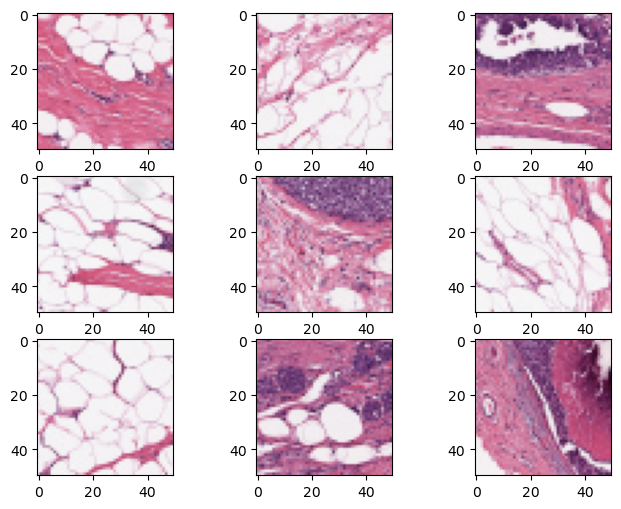

In [38]:
# Plot 3x3 positieve afbeeldingen (directory 1)
fig, ax = plt.subplots(3, 3, figsize=(8, 6))
for r in range(3):
    for c in range(3):
        idx = np.random.choice(len(imgs_positive))
        img = Image.open(f'{patient_id}/1/{imgs_positive[idx]}')
        ax[c, r].imshow(img, cmap='gray')
print("cancerous:")
plt.show()

# Plot 3x3 negatieve afbeeldingen (directory 0)
fig, ax = plt.subplots(3, 3, figsize=(8, 6))
for r in range(3):
    for c in range(3):
        idx = np.random.choice(len(imgs_negative))
        img = Image.open(f'{patient_id}/0/{imgs_negative[idx]}')
        ax[c, r].imshow(img, cmap='gray')
print("healthy:")
plt.show()

Bij het bekijken van weefselafbeeldingen valt op dat kankercellen doorgaans een intensere paarse kleur hebben, veroorzaakt door een hogere kernendichtheid (donkerpaarse kleuring door hematoxyline). Gezond weefsel bevat meer witte gebieden door extracellulaire ruimtes of vetweefsel en heeft een meer georganiseerde structuur. Deze kleurverschillen zijn nuttig voor classificatie tussen kankercellen en gezond weefsel. Dit klopt met de literatuur. 

In [39]:
# Functie om x-coördinaat uit bestandsnaam te halen
def get_x(filename):
    if filename.startswith('.'):
        return 0
    t = filename.split('_')
    return int(t[2][1:])

# Functie om y-coördinaat uit bestandsnaam te halen
def get_y(filename):
    if filename.startswith('.'):
        return 0
    t = filename.split('_')
    return int(t[3][1:])

# Test de functies met een willekeurige positieve afbeelding
idx = np.random.choice(len(imgs_positive))
fn = f'{patient_id}/1/{imgs_positive[idx]}'
print(fn)
print(f'x: {get_x(fn)}, y: {get_y(fn)}')

../data/idc_regular/8863/1/8863_idx5_x1351_y1201_class1.png
x: 0, y: 0


### Missende waarden